In [ ]:
'''
Deep Learning
Assignment 1

The objective of this assignment is to learn about simple data curation practices, 
and familiarize you with some of the data we'll be reusing later.

This notebook uses the notMNIST dataset to be used with python experiments. 
This dataset is designed to look like the classic MNIST dataset, while looking
a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.
'''

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
import tarfile
from numpy import random
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline



In [ ]:
'''First, we'll download the dataset to our local machine. The data consists of characters 
rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J'
(10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, 
it should be possible to train models quickly on any machine.'''

In [ ]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


In [ ]:
'''Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.'''

In [ ]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


In [ ]:
'''Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we
just downloaded. Hint: you can use the package IPython.display'''

In [ ]:
#set path to directories where image data is stored
path_large='./notMNIST_large/' # train dataset
path_small='./notMNIST_small/'# test dataset

imgFiles_large = os.listdir(path_large)
imgFiles_small = os.listdir(path_small)


#iterate through small images
for i in range(0,3):
    random_index_path = random.randint(0,len(imgFiles_small))#in numpy the randint includes the last number        
    
    temp_path = path_small + imgFiles_small[random_index_path] #path to random directory
    temp_list_img = os.listdir(temp_path) #list all images of files within random directory    
       
    radom_index_img = random.randint(0,len(temp_list_img))
    
    #pick some random image
    final_path_image = temp_path +'/'+ temp_list_img[radom_index_img]
       
    print(final_path_image) #print final path  
        

    #image = mpimg.imread(final_path_image) #image from path
    #image_plot = plt.imshow(image)
    #plt.show()
    


#print(image_data)



In [ ]:
'''

Now let's load the data in a more manageable format. Since, depending on your computer setup 
you might not be able to fit it all in memory, we'll load each class into a separate dataset, 
store them on disk and curate them independently. Later we'll merge them into a single dataset 
of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, 
normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.
'''

In [28]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset


#pick images from folders
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

#save 3D datasets into *.pickle file
train_datasets = maybe_pickle(train_folders, 45000) #stores data sets in a single file per label
test_datasets = maybe_pickle(test_folders, 1800) #stores data sets in a single file per label

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825006
Standard deviation: 0.44312045
Pickling ./notMNIST_large/B.pickle.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.007563043
Standard deviation: 0.45449153
Pickling ./notMNIST_large/C.pickle.
./notMNIST_large/C
Full dataset tensor: (52912, 2

In [ ]:
'''Let's verify that the data still looks good. Displaying a sample of the labels
and images from the ndarray. Hint: you can use matplotlib.pyplot.
'''

In [43]:
print(train_datasets) # just pick some random data set

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']


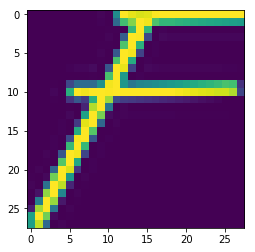

52912


In [59]:
fileObject = open(train_datasets[5],'rb') #open file in bynary reading mode
# load the object from the file into variable
testData = pickle.load(fileObject)  
#print(A_testData[1,:,:])
img = testData[3,:,:]
imgplot = plt.imshow(img)
plt.show()

print(testData.shape[0]) 
#close file after use, thank you
fileObject.close()


In [60]:
'''
Problem 3

Another check: we expect the data to be balanced across classes. Verify that.'''


[]


In [65]:
'''Data set is balanced is when the std deviation of number of samples of classes 
is low and number of samples is close to mean'''

#empty helper array to store number of samples
num_samples = np.array([])

#open each class
for label_class in train_datasets:
    with open(label_class, 'rb') as fileObj:  # Use file to refer to the file object
        testData = pickle.load(fileObj) 
        curNumSamples = testData.shape[0]
    num_samples = np.append(num_samples, curNumSamples)

print (num_samples)
print ('Mean of samples', num_samples.mean()) #calculate mean
print ('SD of samples', np.std(num_samples)) #calculate std deviation

[52909. 52911. 52912. 52911. 52912. 52912. 52912. 52912. 52912. 52911.]
Mean of samples 52911.4
SD of samples 0.9165151389911681


In [ ]:
'''
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.
'''



def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels